# <center> <span style="color:indigo">       Deep Learning</span> </center> 
##  <center> <span style="color:DarkBlue">       Tarea 3. Detección de manzanas frescas y podridas utilizando Transfer Learning (TL). </span>  </center>
##  <center> <span style="color:DarkBlue"> Karla Guadalupe Ornelas Gamero</span>  </center>
##  <center> <span style="color:DarkBlue"> karla.gameroo@gmail.com</span>  </center>
##  <center> <span style="color:DarkBlue"> septiembre 2024</span>  </center>

##  Contenido
1. <span style="color:DarkBlue">Planteamiento del problema (qué hacer)</span>
2. <span style="color:DarkBlue">Planteamiento de la solución (cómo se hizó)</span>
3. <span style="color:DarkBlue">Ejemplo de ejecución (código)</span>
4. <span style="color:DarkBlue">Conclusiones </span>
5. <span style="color:DarkBlue">Referencias</span>


## <span style="color:DarkBlue"> 1. Planteamiento del problema</span>
Utilizando el modelo pre entrenado de colores (color_weights.hdf5), determinar de un conjunto de manzanas el estado de madurez: fresca o podrida. Entrenar el modelo con las capas de color RGB necesarias para una mejor exactitud:
Analizar la CNN que se utiliza para el reconocimiento de los colores
Extraer el dataset de Apples.zip en carpetas de train y test, para frutas frescas y podridas        
Encender las capas de color (extract_color_channel()) necesarias para que el modelo tenga una mejor exactitud
Ejecutar el modelo
Mostrar predicciones con el modelo entr
enado
## <span style="color:DarkBlue">2. Planteamiento de la solución</sPara resolver esta tarea modificaremos un poco los parametros del modelo para que pueda entrenar bien aplicaremos el modelo para que se entrene  y al final haremos pruebas con difernetes imagenes.
os. 

El código es: entrenado

### Importamos librerias

In [2]:


import os
import tensorflow as tf
from PIL import Image
from keras.models import Sequential,Model,load_model
from keras.optimizers import SGD, Adam
from keras.layers import BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Reshape, Activation, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from sklearn.utils.class_weight import compute_class_weight



In [3]:
#Revisar estado de la GPU
tf.config.list_physical_devices('GPU')

[]

### MODELO

Este modelo es una red neuronal convolucional para clasificar imagenes
Primero ingresa las entradas con un tamaño de 250x2540 con 3 canales de color
Hay dos ramas convolucionales la superior y la inferior que combinan sus resultados para formar una salida combinada
La salida combinada se aplana y pasa por dos capas densas usando la activacion relu
Para prevenir sobreajuste se aplican capas dropout, la capa de salida utiliza una activacion softmax
Por el ultimo el modelo compilado utiliza un optimizador adam con una tasa del  1e-3 ,y la funcion de perdida es  categorical_crossentropy


In [4]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(250,250,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=512, activation='relu')(flatten)
    #Mejorar el modelo con un Dropout
    FC_1 = Dropout(0.5)(FC_1)
    FC_2 = Dense(units=256, activation='relu')(FC_1)
    #Dropout(0.3)(FC_2)
    FC_2 = Dropout(0.5)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    #Modelo con descenso de gradiente estocástico SGD
    #sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    
    #Modelo Adam
    adam= Adam(lr=1e-3)
    model.compile(optimizer=adam , loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [5]:
model = color_net(2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 60, 60, 48)   17472       ['input_1[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 60, 60, 48)   17472       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 60, 60, 48)  192         ['conv2d[0][0]']             

C:\Users\Karla\anaconda3\envs\DL\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


La decision de comentar el codigo de colores se debe a que , en las imagenes de prueba hay manzanas rojas y verdes y los colores que tienen
no todos son rojos brillantes aveces son un poco rojos cafes, entonces para que aprenda a diferenciar los colores es mejor que el mismoi
detecte los colores correctos en vez de nosotros darle el color

In [6]:
def extract_color_channel(image):
    #color_image = image.copy()

    # Apagar canal azul 
    #color_image[:, :, 2] = 0 

    # Resaltar ligeramente el rojo 
    #color_image[:, :, 0] *= 1.1  # Incrementar rojo
    
    # Resaltar ligeramente el verde 
    #color_image[:, :, 1] *= 1.1  # Incrementar verde

    # Rango de colores entre [0, 255]
    #color_image = np.clip(color_image, 0, 255)


    return image


### Entrenamiento

In [7]:
img_rows , img_cols = 250,250
num_classes = 2
batch_size = 32
numb_epoch = 30
steps_per_epoch = 50
validation_steps = 12

# initialise model
model = color_net(num_classes)

# filepath = 'color_weights.hdf5' reusar el modelo de colores
filepath = 'color_weights.hdf5'


train_datagen = ImageDataGenerator(
        preprocessing_function=extract_color_channel,
        rescale=1./255,
        rotation_range=10,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(
        preprocessing_function=extract_color_channel,
        rescale=1./255)
#Pasar como parámtros las rutas del dataset que se desea nalizar
#OHE para etiquetas con class_mode='categorical'
training_set = train_datagen.flow_from_directory(
            'Apples/train',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical')
test_set = test_datagen.flow_from_directory(
            'Apples/test',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical')

total_samples = training_set.n

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
class_weights = compute_class_weight('balanced', classes=np.unique(training_set.classes), y=training_set.classes)
class_weights_dict = dict(enumerate(class_weights))


history = model.fit(
    training_set,
    steps_per_epoch=steps_per_epoch,
    epochs=numb_epoch,
    validation_data=test_set,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,  # Add class weights here
    callbacks=callbacks_list,
    verbose=1
)

Found 4035 images belonging to 2 classes.
Found 996 images belonging to 2 classes.
Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.7575
Epoch 1: val_accuracy improved from -inf to 0.61719, saving model to color_weights.hdf5
50/50 [==============================] - 57s 1s/step - loss: 0.7422 - accuracy: 0.7575 - val_loss: 0.6829 - val_accuracy: 0.6172
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8750
Epoch 2: val_accuracy improved from 0.61719 to 0.63021, saving model to color_weights.hdf5
50/50 [==============================] - 53s 1s/step - loss: 0.3223 - accuracy: 0.8750 - val_loss: 0.6413 - val_accuracy: 0.6302
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9006
Epoch 3: val_accuracy improved from 0.63021 to 0.68490, saving model to color_weights.hdf5
50/50 [==============================] - 49s 972ms/step - loss: 0.2537 - accuracy: 0.9006 - val_loss: 0.599

### Graficacion de metricas de perdidas y precision

En las graficas podemos precenciar que el modelo logra altas precisiones tanto en el entrenamiento como en la validacion, fluctuaciones y las perdidas en el conjunto de validacion lo que podria siginificar un sobreajuste

Text(0.5, 1.0, 'Loss in training and validation')

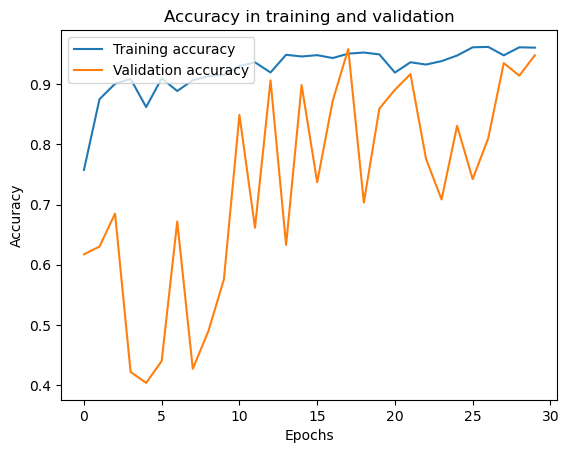

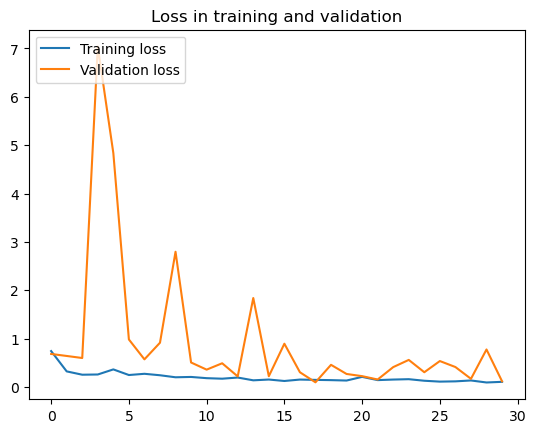

In [8]:
# get the metrics from history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

# plot accuracy with matplotlib
plt.plot(epochs, acc, label = "Training accuracy")
plt.plot(epochs, val_acc, label = "Validation accuracy")
plt.legend(loc = "upper left")
plt.title('Accuracy in training and validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.figure()

# plot loss with matplotlib
plt.plot(epochs, loss, label = "Training loss")
plt.plot(epochs, val_loss, label = "Validation loss")
plt.legend(loc = "upper left")
plt.title('Loss in training and validation')

In [9]:
#Realizar predicciones con furtas fresacas o podridas
imagen1="prueba1.png"
#imagen2="manzana2p.png"
imagen2="prueba2.png"

imagen3="prueba2.png"

imagen4="prueba3.png"


imagen5="prueba4.png"

imagen6="prueba5.png"

imagen7="prueba6.png"



In [10]:
#Uso de la función de predicción
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(250,250))

    plt.imshow(img1)

    Y = image.img_to_array(img1)

    X = np.expand_dims(Y,axis=0)
    X /= 255
    val = model.predict(X)[0]
    print(val)
    clase = np.argmax(val)
    print(clase)
    if clase == 0:
        plt.xlabel("Fresca",fontsize=30)
    elif clase == 1:
        plt.xlabel("Podrida",fontsize=30)

1/1 [==============================] - 1s 596ms/step
[0.99877125 0.00122874]
0


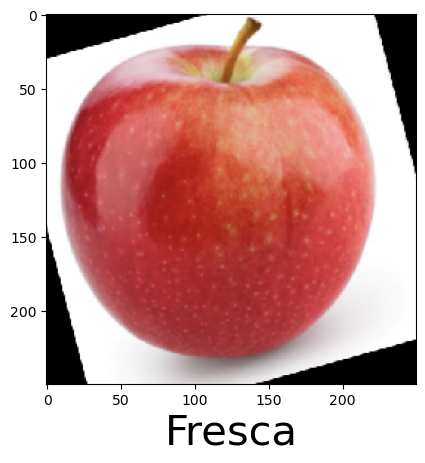

In [11]:
#Se usa el modelo entrenado
predictImage(imagen1)

1/1 [==============================] - 0s 29ms/step
[9.9999976e-01 1.8471425e-07]
0


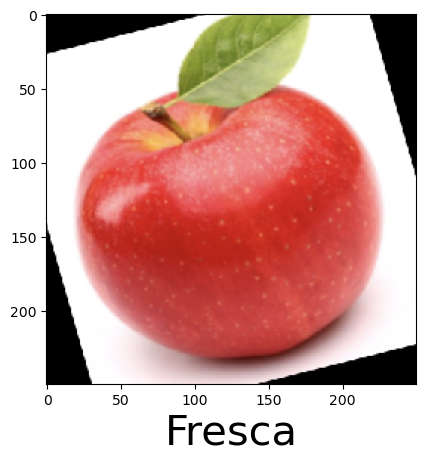

In [12]:
predictImage(imagen2)

1/1 [==============================] - 0s 45ms/step
[4.3302603e-05 9.9995673e-01]
1


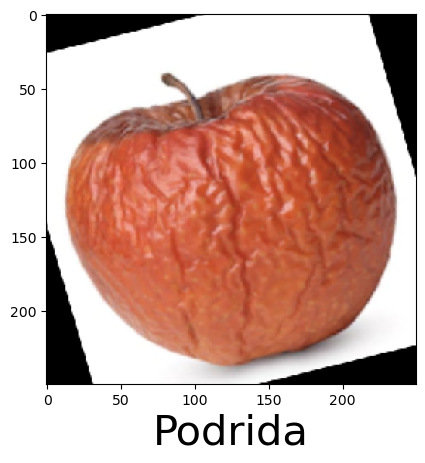

In [13]:
predictImage(imagen4)

1/1 [==============================] - 0s 38ms/step
[9.994350e-01 5.649474e-04]
0


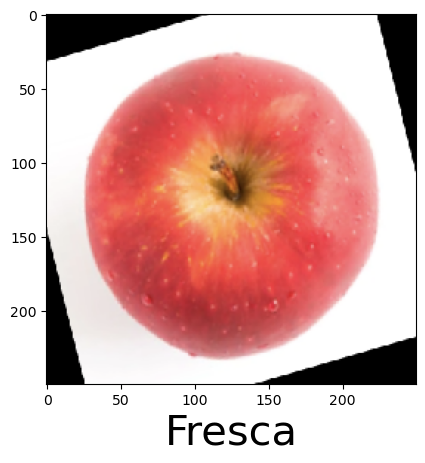

In [14]:
predictImage(imagen3)

1/1 [==============================] - 0s 31ms/step
[0.01863711 0.98136294]
1


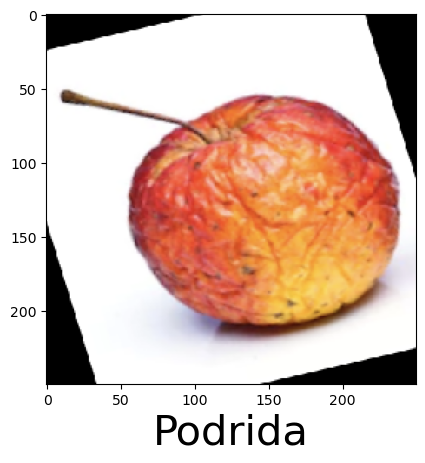

In [15]:
predictImage(imagen5)

1/1 [==============================] - 0s 31ms/step
[5.8144383e-06 9.9999416e-01]
1


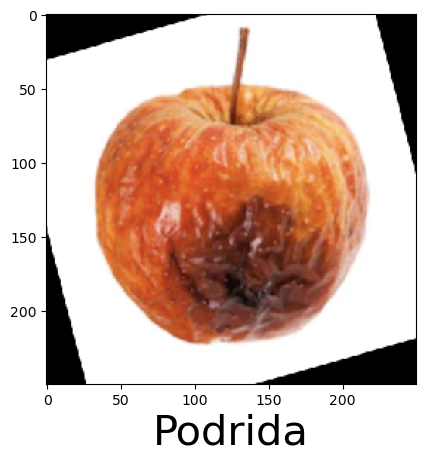

In [16]:
predictImage(imagen6)

1/1 [==============================] - 0s 36ms/step
[2.5611677e-09 1.0000000e+00]
1


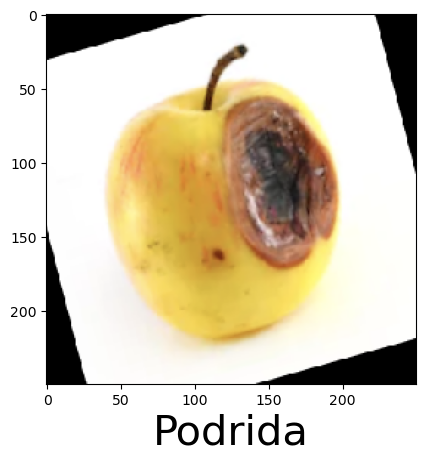

In [17]:
predictImage(imagen7)

## <span style="color:DarkciónBlue"> 4. Conclusión</span>
Con los cambios significativos de las activaciones de las capas, y el cambio del dropout para el sobreaprendizaje, tambien el dejar al modelo identificar los colores que si son de manzanas frescas tuvimos o alcanzamos una precision del 94% lo cual es muy bueno acomparacion con el que empezamos de 64% ademas que ya puedo identificar en las 7 pruebas si la manzana es podrida o fresca lo cual es sumamente bueno. 
En conclusion esas modificaciones nos ayudaron a alcanza mas de un 90% de precision haciendolo un modelo prometedor